<a href="https://colab.research.google.com/github/stevegbrooks/big-portfolio-learner/blob/get_all_other_data/big_portfolio_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 545 Final Project

## Big Portfolio Learner

### Team members: Steven Brooks & Chenlia Xu

In [ ]:
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [ ]:
## If boto3 not already installed uncomment the following:
!pip3 install boto3

     |████████████████████████████████| 131 kB 5.1 MB/s 
     |████████████████████████████████| 79 kB 6.5 MB/s 
     |████████████████████████████████| 8.4 MB 30.0 MB/s 
     |████████████████████████████████| 138 kB 9.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('cis545project').download_file('data/stock_data.zip', 'stock_data.zip')

In [ ]:
%%capture

in_dir = "stock_data"
if not os.path.exists(in_dir):
  os.makedirs(in_dir)
!unzip /content/stock_data.zip -d /content/$in_dir
!rm -f $in_dir/.gitempty


tech_dir = "technical_data"
if not os.path.exists(tech_dir):
  os.makedirs(tech_dir)
!unzip /content/technical_data.zip -d /content/$tech_dir
!rm -f $tech_dir/.gitempty

# Section 1: Exploratory Data Analysis of the Stock Data

The schema of the stock data is as below:

In [ ]:
import random
stock_data_files = os.listdir(in_dir)

# head of a random file
pd.read_csv(os.path.join(in_dir, stock_data_files[random.randrange(len(stock_data_files))])).head(5)

,symbol,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,ORA,2021-12-03,79.69,79.690,76.685,77.46,77.46,262547,0.0,1.0
1,ORA,2021-12-02,76.65,79.730,76.600,79.26,79.26,289599,0.0,1.0
2,ORA,2021-12-01,77.00,78.815,76.530,76.54,76.54,458277,0.0,1.0
3,ORA,2021-11-30,76.11,77.195,75.190,75.50,75.50,284256,0.0,1.0
4,ORA,2021-11-29,77.52,77.660,76.380,76.92,76.92,267751,0.0,1.0


### Step 0: Inspect the data

First look at the number of rows of data across within each year for each stock.  

In [ ]:
def add_year_col(df: pd.DataFrame, timestamp_col: str) -> pd.DataFrame:
  """ 
  Assumes the input df has a column that needs to be converted into datetime
  using datetime.strptime function and "%Y-%m-%d" format
  """
  new_col_name = timestamp_col + '_as_dt'
  df[new_col_name] = df[timestamp_col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
  if len(df[new_col_name].unique()) != len(df[timestamp_col].unique()):
    raise Exception("error in timestamp parsing")
  df['year'] = pd.to_numeric(df[new_col_name].dt.year)
  return df


In [ ]:
rows_per_year = dict()

for data_file in stock_data_files:
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_col(stock_data, "timestamp")
  rows_per_year[data_file] = dict(stock_data.groupby(by = 'year').size())

print(rows_per_year)

{'ATAI.csv': {2021: 118}, 'KTTA.csv': {2021: 57}, 'SR.csv': {1999: 43, 2000: 252, 2001: 248, 2002: 252, 2003: 252, 2004: 252, 2005: 252, 2006: 251, 2007: 251, 2008: 253, 2009: 252, 2010: 252, 2011: 252, 2012: 250, 2013: 252, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'SCOBW.csv': {2021: 168}, 'AMAO.csv': {2021: 149}, 'FUV.csv': {2017: 70, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'KSU.csv': {1999: 43, 2000: 252, 2001: 248, 2002: 252, 2003: 252, 2004: 252, 2005: 252, 2006: 251, 2007: 251, 2008: 253, 2009: 252, 2010: 252, 2011: 252, 2012: 250, 2013: 252, 2014: 252, 2015: 252, 2016: 252, 2017: 251, 2018: 251, 2019: 252, 2020: 253, 2021: 233}, 'YSAC.csv': {2020: 17, 2021: 233}, 'MACC-U.csv': {2021: 192}, 'BHFAN.csv': {2020: 35, 2021: 233}, 'AFBI.csv': {2021: 221}, 'MGRB.csv': {2020: 66, 2021: 233}, 'FDBC.csv': {2001: 248, 2002: 252, 2003: 252, 2004: 251, 2005: 252, 2006: 251, 2007: 250, 2008: 252, 2009: 252, 2010: 252, 2011: 245, 2012: 250, 

#### We'll just look at the data from the years we are interested in: 2002 to 2019.

In [ ]:
analysis_years = range(2002, 2020)

27 stocks have data in each of the years in range(2002, 2020)
There are 4 unique rows-per-year patterns among those stocks


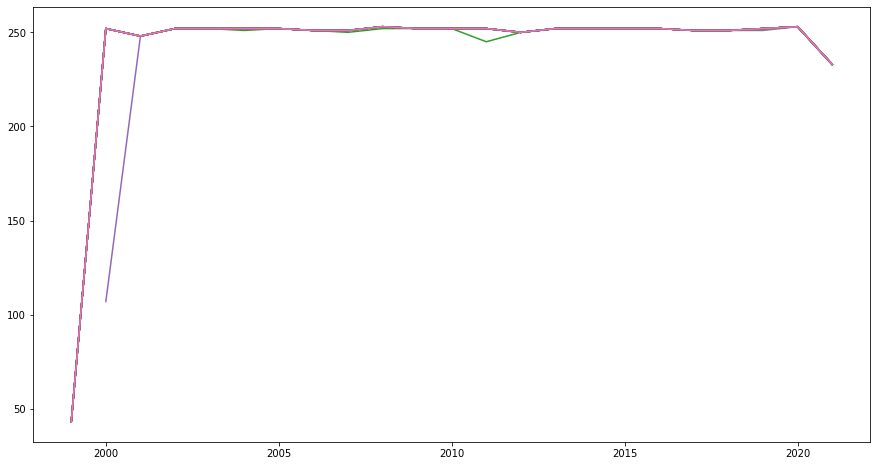

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8

count_unique = 1
stocks_with_all_analysis_yrs = []
last = None

for i, (key, rows_dict) in enumerate(rows_per_year.items()):
  if all(analysis_year in rows_dict for analysis_year in analysis_years):
    stocks_with_all_analysis_yrs.append(key)
    if last is None: last = rows_dict
    elif rows_dict != last: count_unique += 1
    as_list = sorted(rows_dict.items())
    year, row_count = zip(*as_list)
    plt.plot(year, row_count)

print(len(stocks_with_all_analysis_yrs), "stocks have data in each of the years in", analysis_years)
print("There are", count_unique, "unique rows-per-year patterns among those stocks")

### Step 1: Visualize the time series data of adjusted closing price per day over this span.

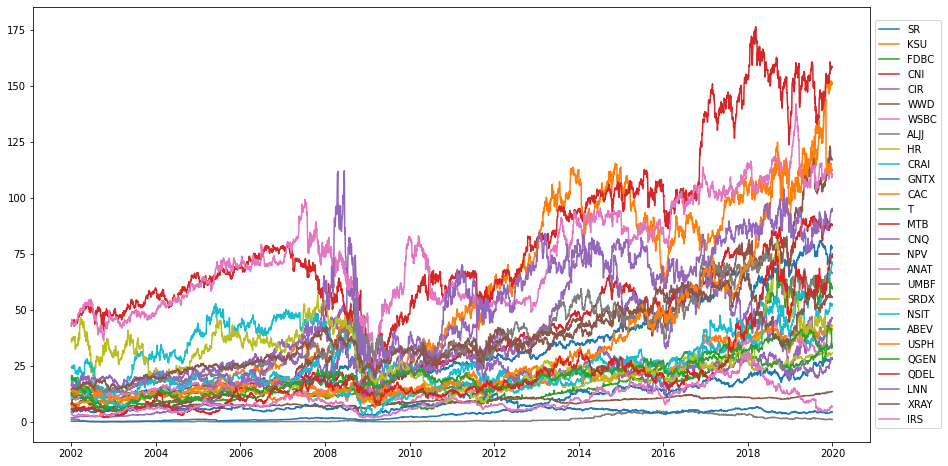

In [ ]:
for i, data_file in enumerate(stocks_with_all_analysis_yrs):
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_col(stock_data, "timestamp")
  stock_data = stock_data[stock_data.year.isin(analysis_years)]
  stock_data.reset_index(inplace = True)
  plt.plot(stock_data.timestamp_as_dt, stock_data.adjusted_close, label = stock_data.symbol[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Step 2: Stationarize the series

Next we'll have to check if our time series data is stationary, and stationarize it if it isnt

In [ ]:
#check for stationarity


### Step 3: Add features to stock price

Add independent variables into dataframe as features for one particular stock as an example.  
Try using pandas before running huge data in spark.  

In [ ]:
ticker = 'ABM.csv'                      # change ticker to try different stock

stock_data = pd.read_csv(os.path.join(in_dir, ticker)).copy()
stock_data = stock_data.drop(columns=['open', 'high', 'low', 'close', 'volume', 'dividend_amount', 'split_coefficient'])

technical_data = pd.read_csv(os.path.join(tech_dir, ticker)).copy()
technical_data = technical_data.drop(columns=['symbol'])

stock_df = pd.merge(stock_data, technical_data, on='timestamp')
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5501 entries, 0 to 5500
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symbol            5501 non-null   object 
 1   timestamp         5501 non-null   object 
 2   adjusted_close    5501 non-null   float64
 3   SMA               5501 non-null   float64
 4   EMA               5501 non-null   float64
 5   MACD              5501 non-null   float64
 6   MACD_Hist         5501 non-null   float64
 7   MACD_Signal       5501 non-null   float64
 8   SlowD             5501 non-null   float64
 9   SlowK             5501 non-null   float64
 10  RSI               5501 non-null   float64
 11  Real_Lower_Band   5501 non-null   float64
 12  Real_Middle_Band  5501 non-null   float64
 13  Real_Upper_Band   5501 non-null   float64
dtypes: float64(12), object(2)
memory usage: 644.6+ KB


### Step 4: Check correlation of stock and technical data to find pattern.  

Check correlation of stock and technical data.  
Plot the correlation matrix.  

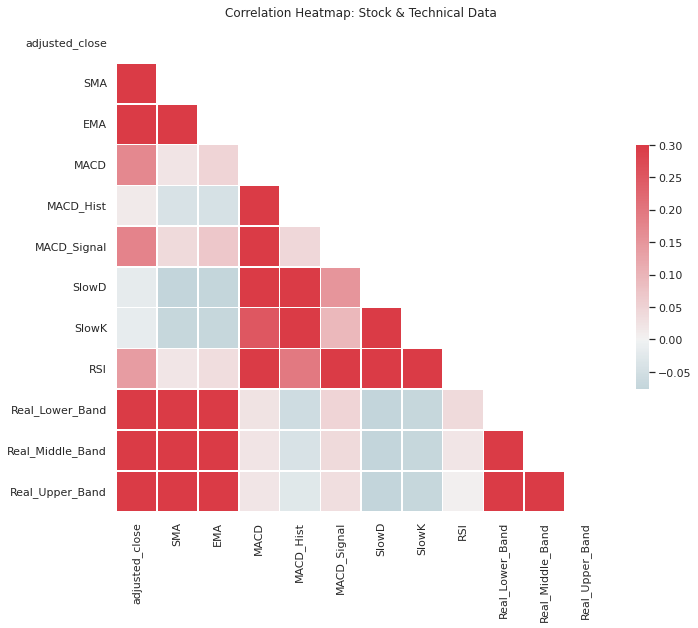

In [ ]:
corr = stock_df.corr(method ='pearson')

from string import ascii_letters

sns.set(style = "white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Heatmap: Stock & Technical Data")
plt.show()

### Step 5: Run linear regression on adjusted_close with technical data 
features.  

In [ ]:
# ML
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Statistics
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

formula = 'adjusted_close ~ SMA + EMA + MACD + MACD_Hist + MACD_Signal + SlowD + SlowK + RSI + Real_Lower_Band + Real_Middle_Band + Real_Upper_Band'
model1 = smf.ols(formula=formula, data=stock_df).fit()
print(model1.params)
model1.summary()



Intercept           -3.919292
SMA                 44.312710
EMA                  1.087606
MACD                48.179520
MACD_Hist          -44.804852
MACD_Signal        -45.952384
SlowD               -0.013489
SlowK                0.015265
RSI                  0.073288
Real_Lower_Band    -44.345626
Real_Middle_Band    44.312710
Real_Upper_Band    -44.359599
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         adjusted_close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 4.287e+05
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:19:50   Log-Likelihood:                -2499.3
No. Observations:                5501   AIC:                             5021.
Df Residuals:                    5490   BIC:                             5093.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.9193      0.081    -48.256      0.000      -4.079      -3.760
SMA                 44.3127     73.101      0.606      0.544     -98.995     187.620
EMA                  1.0876      0.024     45.891      0.000       1.041       1.134
MACD                48.1795    101.921      0.473      0.636    -151.627     247.986
MACD_Hist          -44.8049    101.921     -0.440      0.660    -244.611     155.001
MACD_Signal        -45.9524    101.922     -0.451      0.652    -245.760     153.855
SlowD               -0.0135      0.001    -25.652      0.000      -0.015      -0.012
SlowK                0.0153      0.000     32.255      0.000       0.014       0.016
RSI                  0.0733      0.002     44.082      0.000       0.070       0.077
Real_Lower_Band    -44.3456     73.101     -0.607      0.544    -187.653      98.961
Real_Middle_Band    44.3127     73.101      0.606      0.544     -98.995     187.620
Real_Upper_Band    -44.3596     73.101     -0.607      0.544    -187.667      98.947
==============================================================================
Omnibus:                     1089.517   Durbin-Watson:                   0.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34536.237
Skew:                           0.103   Prob(JB):                         0.00
Kurtosis:                      15.273   Cond. No.                     1.36e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.35e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Step 6: Divide the dataset into training and testing.  Run linear regression model on training dataset and evaluate the model on testing dataset.  

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing

train, test = train_test_split(stock_df, test_size=0.20, random_state=42)

list_of_features = ['SMA','EMA','MACD','MACD_Hist','MACD_Signal','SlowD','SlowK','RSI','Real_Lower_Band','Real_Middle_Band','Real_Upper_Band']
X_train = train[list_of_features]
y_train = train[['adjusted_close']]
X_test = test[list_of_features]
y_test = test[['adjusted_close']]

# Run linear regression model on training dataset and then test model

model2 = smf.ols(formula=formula, data=train).fit()
y_pred = model2.predict(X_test)

# Evaluate performance of linear regression model

print('R Squared =', model2.rsquared)
print('R Squared_adj =', model2.rsquared_adj)
print('MAE =', mean_absolute_error(y_test, y_pred))
print('MSE =', mean_squared_error(y_test, y_pred))
print('RMSE =', np.sqrt(mean_squared_error(y_test, y_pred)))


R Squared = 0.9987284873094353
R Squared_adj = 0.9987255902652554
MAE = 0.2591705707442236
MSE = 0.15748895276002223
RMSE = 0.3968487782014986


# Section 2: Structuring Data: Acquisition, Wrangling, Integration, Cleaning.  

### Step 0: Setting up AWS environment

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev
!pip install sparkmagic

%load_ext sparkmagic.magics 

%spark add -s spark_session -l python -u 	http://ec2-54-146-11-159.compute-1.amazonaws.com -a cis545-livy -p 2wsxxsw2 -t Basic_Access

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *


An error was encountered:
Error sending http request and maximum retry encountered.


### Step 1: Acquire stock price data for 500 stocks over the period of 2002-2019.  

In [ ]:
import math

stock_data_files = os.listdir(in_dir)
print(len(stock_data_files))

all_stock_data = pd.DataFrame()

for file in stock_data_files: 
    stock_data = pd.read_csv(os.path.join(in_dir, file))
    all_stock_data = all_stock_data.append(stock_data)

all_stock_data = all_stock_data[['symbol', 'timestamp', 'adjusted_close']]
all_stock_data['timestamp'] = pd.to_datetime(all_stock_data.timestamp)
all_stock_data = all_stock_data[all_stock_data['timestamp'] < pd.Timestamp(2020,1,1)]
all_stock_data['price_DoD'] = all_stock_data['adjusted_close'].pct_change(1)

# add quarter / month column
all_stock_data['quarter'] = all_stock_data['timestamp'].dt.to_period('Q')
all_stock_data['month'] = all_stock_data['timestamp'].dt.to_period('M')

all_stock_data.head()

100


,symbol,timestamp,adjusted_close,price_DoD,quarter,month
486,USPH,2019-12-31,112.408365,NaN,2019Q4,2019-12
487,USPH,2019-12-30,111.926685,-0.004285,2019Q4,2019-12
488,USPH,2019-12-27,112.064308,0.001230,2019Q4,2019-12
489,USPH,2019-12-26,112.044648,-0.000175,2019Q4,2019-12
490,USPH,2019-12-24,113.578159,0.013687,2019Q4,2019-12


### Step 2: Acquire independent variable data.  

2(a) Acquire last-twelve-month (LTM) price-to-sales (P/S), price-to-earning (P/E), price-to-book (P/B), price-to-cashflow (P/CF) ratio of each quarter.  

2(b) Acquire quarterly revenue, adjusted earning, cash flow yoy growth rate.  

2(c) Acquire prior day technical indicators of respective stock, including SMA, EMA, VWAP, MACD, STOCH, RSI, ADX, CCI, AROON, BBANDS, AD, OBV.  

2(d) Acquire overnight stock index performance of other major stock markets, e.g. FTSE, DAX, CAC, Nikkei, HKSE, SHSE.

In [ ]:
stockindex_data = pd.read_csv('/content/other_data/stockindex.csv')

stockindex_data = stockindex_data[['date', 'FTSE100', 'DAX', 'CAC', 'Nikkei225', 'Hang_Seng', 'SHSZ300']]
stockindex_data['date'] = pd.to_datetime(stockindex_data.date)
stockindex_data = stockindex_data[stockindex_data['date'] < pd.Timestamp(2020,1,1)]

# filling missing data
stockindex_data = stockindex_data.fillna(method='ffill')
stockindex_data.iloc[0, stockindex_data.columns.get_loc('Nikkei225')] = 10871.49
stockindex_data.iloc[1, stockindex_data.columns.get_loc('Nikkei225')] = 10871.49
stockindex_data.iloc[0, stockindex_data.columns.get_loc('SHSZ300')] = 1316.46
stockindex_data.iloc[1, stockindex_data.columns.get_loc('SHSZ300')] = 1316.46

# calculating day-over-day % price change
stockindex_data['FTSE100_DoD'] = stockindex_data['FTSE100'].pct_change(1)
stockindex_data['DAX_DoD'] = stockindex_data['DAX'].pct_change(1)
stockindex_data['CAC_DoD'] = stockindex_data['CAC'].pct_change(1)
stockindex_data['Nikkei225_DoD'] = stockindex_data['Nikkei225'].pct_change(1)
stockindex_data['Hang_Seng_DoD'] = stockindex_data['Hang_Seng'].pct_change(1)
stockindex_data['SHSZ300_DoD'] = stockindex_data['SHSZ300'].pct_change(1)
stockindex_data = stockindex_data[['date', 'FTSE100_DoD', 'DAX_DoD', 'CAC_DoD', 'Nikkei225_DoD', 'Hang_Seng_DoD', 'SHSZ300_DoD']]
                        
stockindex_data.head()

,date,FTSE100_DoD,DAX_DoD,CAC_DoD,Nikkei225_DoD,Hang_Seng_DoD,SHSZ300_DoD
0,2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,0.019259,0.019817,0.021998,0.000000,0.006402,0.000000
2,2002-01-04,0.000940,0.009191,0.000340,0.000000,0.024391,0.000000
3,2002-01-07,-0.005673,-0.016265,-0.014361,0.006519,0.016278,-0.010923
4,2002-01-08,-0.008161,0.000793,-0.010280,-0.022551,-0.015045,-0.007196


2(e) Acquire tresaury bond (1-yr, 3yr, 10-yr) market daily performance

In [ ]:
tbond_data = pd.read_csv('/content/other_data/tbond.csv')

tbond_data = tbond_data[['date', '3M', '1Y', '10Y']]
tbond_data['date'] = pd.to_datetime(tbond_data.date)
tbond_data = tbond_data[tbond_data['date'] < pd.Timestamp(2020,1,1)]

tbond_data['3M_DoD'] = tbond_data['3M'].pct_change(1)
tbond_data['1Y_DoD'] = tbond_data['1Y'].pct_change(1)
tbond_data['10Y_DoD'] = tbond_data['10Y'].pct_change(1)
tbond_data = tbond_data[['date', '3M_DoD', '1Y_DoD','10Y_DoD']]
                        
tbond_data.head()

,date,3M_DoD,1Y_DoD,10Y_DoD
0,2002-01-02,NaN,NaN,NaN
1,2002-01-03,-0.005747,-0.017544,-0.007692
2,2002-01-04,-0.005780,0.004464,0.003876
3,2002-01-07,-0.023256,-0.026667,-0.017375
4,2002-01-08,0.000000,0.000000,0.001965


2(f) Acquire forex market (USD/EUR, USD/JPY, USD/AUD, etc.) daily performance

In [ ]:
forex_data = pd.read_csv('/content/other_data/forex.csv')

forex_data = forex_data[['date', 'USDGBP', 'USDEUR', 'USDJPY', 'USDHKD', 'USDAUD', 'USDCAD']]

# filling missing data
forex_data = forex_data.fillna(method='ffill')

# convert data format
forex_data['date'] = pd.to_datetime(forex_data.date)
forex_data = forex_data[forex_data['date'] < pd.Timestamp(2020,1,1)]

# calculating day-over-day % price change
forex_data['USDGBP_DoD'] = forex_data['USDGBP'].pct_change(1)
forex_data['USDEUR_DoD'] = forex_data['USDEUR'].pct_change(1)
forex_data['USDJPY_DoD'] = forex_data['USDJPY'].pct_change(1)
forex_data['USDHKD_DoD'] = forex_data['USDHKD'].pct_change(1)
forex_data['USDAUD_DoD'] = forex_data['USDAUD'].pct_change(1)
forex_data['USDCAD_DoD'] = forex_data['USDCAD'].pct_change(1)
forex_data = forex_data[['date', 'USDGBP_DoD', 'USDEUR_DoD', 'USDJPY_DoD', 'USDHKD_DoD', 'USDAUD_DoD', 'USDCAD_DoD']]
                        
forex_data.head()

,date,USDGBP_DoD,USDEUR_DoD,USDJPY_DoD,USDHKD_DoD,USDAUD_DoD,USDCAD_DoD
0,2002-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,0.005496,-0.003692,0.000304,-0.000026,-0.000412,0.001317
2,2002-01-04,-0.006185,0.009219,-0.004331,0.000038,-0.011121,-0.000626
3,2002-01-07,0.004921,0.002418,-0.001908,0.000077,0.004634,-0.000689
4,2002-01-08,0.000720,0.003484,0.014221,0.000013,-0.010158,0.004704


2(g) Acquire economic data, including monthly unemployment rate, quarterly yoy GDP growth

In [ ]:
gdp_data = pd.read_csv('/content/other_data/gdp.csv')

gdp_data = gdp_data[['date', 'real_gdp']]

# filling missing data
gdp_data = gdp_data.fillna(method='ffill')

# convert data format
gdp_data['date'] = pd.to_datetime(gdp_data.date)
gdp_data = gdp_data[gdp_data['date'] < pd.Timestamp(2020,1,1)]
gdp_data['real_gdp_QoQ'] = gdp_data['real_gdp'].pct_change(1)
gdp_data = gdp_data.drop(columns=['real_gdp'])

# add quarter column
gdp_data['quarter'] = gdp_data['date'].dt.to_period('Q')

gdp_data.head()

,date,real_gdp_QoQ,quarter
0,2002-03-31,NaN,2002Q1
1,2002-06-30,0.006159,2002Q2
2,2002-09-30,0.004029,2002Q3
3,2002-12-31,0.001308,2002Q4
4,2003-03-31,0.005166,2003Q1


2(h) Acquire monthly unemployment data.  

In [ ]:
unemployment_data = pd.read_csv('/content/other_data/unemployment.csv')

unemployment_data = unemployment_data[['date', 'unemployment']]

# filling missing data
unemployment_data = unemployment_data.fillna(method='ffill')

# convert data format
unemployment_data['date'] = pd.to_datetime(unemployment_data.date)
unemployment_data = unemployment_data[unemployment_data['date'] < pd.Timestamp(2020,1,1)]
unemployment_data['unemployment_MoM'] = unemployment_data['unemployment'].pct_change(1)
unemployment_data = unemployment_data.drop(columns=['unemployment'])

# add month column
unemployment_data['month'] = unemployment_data['date'].dt.to_period('M')

unemployment_data.head()

,date,unemployment_MoM,month
0,2002-01-31,NaN,2002-01
1,2002-02-28,0.000000,2002-02
2,2002-03-31,0.000000,2002-03
3,2002-04-30,0.035088,2002-04
4,2002-05-31,-0.016949,2002-05


### Step 3: Merge 2(a) - 2(h) into a single dataframe.  

In [ ]:
mega_data = all_stock_data.merge(stockindex_data, left_on='timestamp', right_on='date', how='left')
mega_data = mega_data.merge(tbond_data, left_on='timestamp', right_on='date', how='left')
mega_data = mega_data.merge(forex_data, left_on='timestamp', right_on='date', how='left')
mega_data = mega_data.merge(gdp_data, left_on='quarter', right_on='quarter', how='left')
mega_data = mega_data.merge(unemployment_data, left_on='month', right_on='month', how='left')

mega_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186682 entries, 0 to 186681
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   symbol            186682 non-null  object        
 1   timestamp         186682 non-null  datetime64[ns]
 2   adjusted_close    186682 non-null  float64       
 3   price_DoD         186681 non-null  float64       
 4   quarter           186682 non-null  period[Q-DEC] 
 5   month             186682 non-null  period[M]     
 6   date_x            172504 non-null  datetime64[ns]
 7   FTSE100_DoD       172477 non-null  float64       
 8   DAX_DoD           172477 non-null  float64       
 9   CAC_DoD           172477 non-null  float64       
 10  Nikkei225_DoD     172477 non-null  float64       
 11  Hang_Seng_DoD     172477 non-null  float64       
 12  SHSZ300_DoD       172477 non-null  float64       
 13  date_y            171193 non-null  datetime64[ns]
 14  3M_D

### Step 4:  Cleanning data

In [ ]:
mega_data = mega_data.drop(columns=['date_x', 'date_y', 'date'])
mega_data = mega_data.dropna()
mega_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169360 entries, 1 to 186681
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   symbol            169360 non-null  object        
 1   timestamp         169360 non-null  datetime64[ns]
 2   adjusted_close    169360 non-null  float64       
 3   price_DoD         169360 non-null  float64       
 4   quarter           169360 non-null  period[Q-DEC] 
 5   month             169360 non-null  period[M]     
 6   FTSE100_DoD       169360 non-null  float64       
 7   DAX_DoD           169360 non-null  float64       
 8   CAC_DoD           169360 non-null  float64       
 9   Nikkei225_DoD     169360 non-null  float64       
 10  Hang_Seng_DoD     169360 non-null  float64       
 11  SHSZ300_DoD       169360 non-null  float64       
 12  3M_DoD            169360 non-null  float64       
 13  1Y_DoD            169360 non-null  float64       
 14  10Y_

# Section 3: Run model

### Step 0: Set up environment

In [ ]:
# ML
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Statistics
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Step 1: Try linear regression model

In [ ]:
formula = '''price_DoD ~ FTSE100_DoD + DAX_DoD + CAC_DoD + Nikkei225_DoD + Hang_Seng_DoD + SHSZ300_DoD
            + 3M_DoD + 1Y_DoD + 10Y_DoD + real_gdp_QoQ + unemployment_MoM
            + USDGBP_DoD + USDEUR_DoD + USDJPY_DoD + USDHKD_DoD + USDAUD_DoD + USDCAD_DoD'''
lr_model = smf.ols(formula=formula, data=mega_data).fit()
print(lr_model.params)
lr_model.summary()

SyntaxError: ignored

### Step 2: 

# Section 4: Evaluate Model

### Step 0: 

### Step 1: 